In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from scipy.stats import zscore, pearsonr


In [2]:
dat = pd.read_pickle('../../datasets/NNN/unit_data_full.pkl')

In [6]:
dat[dat['roi'].astype(str).str.contains('F')]

,session,monkey,unit_type,avg_psth,img_psth,avg_firing_rate,snr,snr_max,F_SI,B_SI,O_SI,roi
8254,18,3,1,"[1.7726191282272339, 1.7726191282272339, 1.772...","[[16.666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.5255964994430542, 0.0, 0.0, 1.99726641...",0.135292,42.066010,-0.303824,0.421048,-0.283948,Unknown_19_F
8255,18,3,2,"[0.9333332180976868, 0.9333332180976868, 0.933...","[[0.0, 0.0, 0.0, 8.333333, 0.0, 0.0, 0.0, 8.33...","[0.0, 2.2075045108795166, 3.3112552165985107, ...",0.100386,12.099904,0.154218,0.105169,-0.282658,Unknown_19_F
8256,18,3,4,"[3.851188898086548, 3.851188898086548, 3.85118...","[[8.333333, 0.0, 0.0, 8.333333, 0.0, 0.0, 0.0,...","[4.415011405944824, 2.2075045108795166, 3.3112...",0.201825,8.171472,-0.230209,-0.006040,0.217353,Unknown_19_F
8257,18,3,2,"[8.898811340332031, 8.898811340332031, 8.89881...","[[0.0, 16.666666, 16.666666, 0.0, 16.666666, 8...","[7.200671672821045, 11.563131332397461, 13.034...",0.597427,9.586660,3.583503,-1.472719,-0.895973,Unknown_19_F
8258,18,3,2,"[7.1654791831970215, 7.1654791831970215, 7.165...","[[16.666666, 16.666666, 25.0, 8.333333, 0.0, 1...","[7.62114953994751, 5.4662041664123535, 6.25459...",0.409182,7.409396,0.746591,-0.526087,-0.294437,Unknown_19_F
...,...,...,...,...,...,...,...,...,...,...,...,...
30369,59,3,4,"[3.590477705001831, 3.590477705001831, 3.59047...","[[0.0, 0.0, 12.5, 0.0, 6.25, 0.0, 14.285714, 0...","[3.7842965126037598, 0.946073591709137, 1.4191...",0.182221,10.281075,0.392369,0.131850,-0.569181,AMC3_28_F
30370,59,3,2,"[1.4148808717727661, 1.4148808717727661, 1.414...","[[0.0, 0.0, 0.0, 0.0, 0.0, 7.142857, 0.0, 0.0,...","[1.1713292598724365, 3.7842977046966553, 2.483...",0.244355,17.408373,-0.934648,0.095980,0.763447,AMC3_28_F
30371,59,3,2,"[3.131251335144043, 3.131251335144043, 3.13125...","[[0.0, 7.142857, 6.25, 6.25, 0.0, 0.0, 7.14285...","[6.352211952209473, 2.297607421875, 0.82781434...",0.230215,20.893970,-0.625809,0.034225,0.486750,AMC3_28_F
30372,59,3,1,"[0.3419643044471741, 0.3419643044471741, 0.341...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.142857, 0.0,...","[0.946073591709137, 1.8921476602554321, 0.0, 0...",0.217909,14.874825,-0.013912,-0.408206,0.307100,AMC3_28_F


In [7]:
# =========================
# CONFIG
# =========================
ONSET_MS = 0          # stimulus onset (ms)
WINDOW_MS = 350        # analyze 0-300 ms post onset
BIN_MS = 1             # temporal bin size (ms). If not 1, change indices below
K_RANGE = range(2, 11) # candidates for number of clusters
RANDOM_STATE = 0
N_INIT = "auto"        # or an int (e.g., 20) if on older sklearn
MAX_IMAGES_FOR_RSA = None   # to keep RSA runtime reasonable. None for all images
RSA_METRIC = "correlation"       # correlation type when comparing RDM vectors
SAVE_PREFIX = "clustering_out"

In [8]:
def get_unit_timecourse(row, img_start=None, img_end=None, t_start=None, t_end=None):
    """
    Return a 1D timecourse for a unit, optionally sliced by image and time indices.

    Behavior:
    - If an image slice is requested (img_start or img_end is not None), compute the
      average over that image range from row['img_psth'] (shape: time x images).
    - Otherwise, prefer row['avg_psth'] if present; if absent, average across ALL images
      from row['img_psth'].
    - If t_start/t_end are provided, return avg[t_start:t_end]. If neither is provided,
      return the full available timecourse.

    Parameters
    ----------
    row : pandas.Series
        Must contain 'img_psth' (time x images). Optionally 'avg_psth' (time,).
    img_start, img_end : int or None
        Image index slice [img_start:img_end]. None means open-ended (use all).
    t_start, t_end : int or None
        Time index slice [t_start:t_end]. None means open-ended (use all).

    Returns
    -------
    np.ndarray, shape (T,)
        1D timecourse. If both t_start and t_end are provided, T == (t_end - t_start).

    Raises
    ------
    ValueError
        If shapes are invalid, required fields are missing, or indices are out of range.
    """
    import numpy as np

    # Coerce indices to ints if provided
    def _to_int_or_none(x, name):
        if x is None:
            return None
        try:
            return int(x)
        except Exception:
            raise ValueError(f"{name} must be an int or None (got {x!r})")

    img_start = _to_int_or_none(img_start, "img_start")
    img_end   = _to_int_or_none(img_end,   "img_end")
    t_start   = _to_int_or_none(t_start,   "t_start")
    t_end     = _to_int_or_none(t_end,     "t_end")

    # Decide data source:
    # 1) If an image slice is requested, we must use img_psth.
    # 2) Else, prefer avg_psth if present; fallback to mean over all images from img_psth.
    use_img_slice = (img_start is not None) or (img_end is not None)

    if use_img_slice:
        if "img_psth" not in row or row["img_psth"] is None:
            raise ValueError("img_psth is required when specifying img_start/img_end.")
        A = np.asarray(row["img_psth"])
        if A.ndim != 2:
            raise ValueError(f"img_psth must be 2D (time x images); got ndim={A.ndim}.")
        # Slice images; Python slicing gracefully handles None bounds
        A = A[:, img_start:img_end]
        if A.size == 0 or A.shape[1] == 0:
            raise ValueError("Image slice produced empty array; check img_start/img_end.")
        avg = A.mean(axis=1)
    else:
        if "avg_psth" in row and row["avg_psth"] is not None:
            avg = np.asarray(row["avg_psth"])
            if avg.ndim != 1:
                raise ValueError(f"avg_psth must be 1D; got shape {avg.shape}.")
        else:
            if "img_psth" not in row or row["img_psth"] is None:
                raise ValueError("Need either avg_psth (1D) or img_psth (2D).")
            A = np.asarray(row["img_psth"])
            if A.ndim != 2:
                raise ValueError(f"img_psth must be 2D (time x images); got ndim={A.ndim}.")
            avg = A.mean(axis=1)

    avg = np.asarray(avg).squeeze()
    if avg.ndim != 1:
        raise ValueError(f"Resulting average must be 1D; got shape {avg.shape}.")

    # Time slicing
    if (t_start is None) and (t_end is None):
        out = avg  # full length
    else:
        # Use Python slice semantics
        out = avg[slice(t_start, t_end)]
        # If both bounds provided, enforce expected length to catch OOB silently clipped by slicing
        if (t_start is not None) and (t_end is not None):
            expected = t_end - t_start
            if expected <= 0:
                raise ValueError(f"t_end must be > t_start (got {t_start}, {t_end}).")
            if out.shape[0] != expected:
                raise ValueError(
                    f"Requested time slice [{t_start}:{t_end}] length {expected}, "
                    f"but available produced length {out.shape[0]}. "
                    "Indices may be out of range."
                )

    return out.astype(float, copy=False)


In [9]:
# start and end times calculated from CONFIG 
start = int(ONSET_MS / BIN_MS) 
end = start + int(WINDOW_MS / BIN_MS)

img_start = None# 1000
img_end = None # 1025

# If you haven't computed X yet (or want to recompute using a subset of images), do it here:
timecourses = []
valid_idx = []  # track which unit rows succeed
for i, row in dat.iterrows():
    try:
        # If your helper supports an image subset, use the kwarg (rename as needed):
        # tc = get_unit_timecourse(row, start, end, images=IMAGE_SUBSET)
        tc = tc = get_unit_timecourse(row, img_start=img_start, img_end=img_end, t_start=start, t_end=end)
        timecourses.append(tc)
        valid_idx.append(i)
    except Exception as e:
        print(f"Skipping unit {i}: {e}")

X = np.vstack(timecourses)  # shape: (n_units_valid, T)

# Z-score each unit across time; sanitize inf/NaN
X = zscore(X, axis=1)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [10]:
# -----------------
# Helper: metadata
# -----------------
dat_valid = dat.loc[valid_idx].reset_index(drop=True)  # align 1:1 with rows of X
dat_valid["roi_clean"] = dat_valid["roi"].fillna("Unknown")

def _sel_from_roi(s):
    # last letter (B/O/F) if present; else "Unknown"
    if isinstance(s, str) and len(s) > 0:
        tail = s[-1]
        if tail in {"B", "O", "F"}:
            return tail
    return "Unknown"

dat_valid["sel"] = dat_valid["roi_clean"].apply(_sel_from_roi)

In [11]:
# ------------------------------
# KMeans per group (ROI or sel)
# ------------------------------
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_by_group(
    X, meta, group_col, K_RANGE,
    random_state=RANDOM_STATE, n_init=N_INIT,
    min_units_for_clustering=2
):
    """
    Runs KMeans separately for each group in `group_col`.
    Chooses the best K by silhouette (when possible) within each group.
    Returns a dict with per-group results and a long df for plotting.
    """
    results = {}
    all_plot_frames = []

    T = X.shape[1]
    # More correct time axis in ms (bins -> ms). Your original used indices as ms.
    # If BIN_MS == 1, this is identical to np.arange(start, end).
    time_ms = np.arange(start, end) * BIN_MS

    for group_name, idx_series in meta.groupby(group_col).groups.items():
        idx = np.array(sorted(list(idx_series)))
        Xg = X[idx]
        n = Xg.shape[0]

        if n == 0:
            continue

        # valid Ks for this group: cannot exceed n-1 for silhouette to make sense
        valid_ks = [k for k in K_RANGE if 1 < k < n+1]
        sil_scores = []
        labels_by_k = {}
        inertias = {}

        if n >= min_units_for_clustering and len(valid_ks) > 0:
            for k in valid_ks:
                km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
                labels_k = km.fit_predict(Xg)       # one fit
                inertias[k] = km.inertia_
                # Only compute silhouette when we have >1 cluster actually formed
                if len(np.unique(labels_k)) > 1:
                    sil = silhouette_score(Xg, labels_k)
                else:
                    sil = np.nan
                sil_scores.append((k, sil))
                labels_by_k[k] = labels_k

            # choose K with max silhouette (ignore NaNs); fallback to smallest valid K
            if np.all(np.isnan([s for _, s in sil_scores])):
                best_k = valid_ks[0]
            else:
                best_k = max((kv for kv in sil_scores if not np.isnan(kv[1])),
                             key=lambda kv: kv[1])[0]
            final_labels = labels_by_k[best_k]
        else:
            # Too few units to cluster: assign a single cluster 0
            best_k = 1
            inertias[1] = 0.0
            final_labels = np.zeros(n, dtype=int)
            sil_scores = [(1, np.nan)]

        # stash results
        results[group_name] = {
            "indices": idx,                 # which rows of X belong to this group
            "best_k": best_k,
            "labels": final_labels,         # cluster labels for rows in this group
            "sil_scores": sil_scores,
            "inertias": inertias,
        }

        # Build long frame for plotting cluster means with CI
        df_plot_g = pd.DataFrame({
            "time": np.tile(time_ms, n),
            "response": Xg.flatten(),
            "cluster": np.repeat(final_labels, T),
            group_col: group_name
        })
        all_plot_frames.append(df_plot_g)

    df_plot_all = pd.concat(all_plot_frames, ignore_index=True) if all_plot_frames else pd.DataFrame()
    return results, df_plot_all

In [12]:
# ---------------
# Run per-ROI
# ---------------
roi_results, df_plot_roi = kmeans_by_group(
    X, dat_valid, group_col="roi_clean", K_RANGE=K_RANGE,
    random_state=RANDOM_STATE, n_init=N_INIT
)

# ---------------
# Run per-selectivity (last letter)
# ---------------
sel_results, df_plot_sel = kmeans_by_group(
    X, dat_valid, group_col="sel", K_RANGE=K_RANGE,
    random_state=RANDOM_STATE, n_init=N_INIT
)

In [13]:
# --------------------
# Faceted plots (ROI)
# --------------------
import seaborn as sns
import matplotlib.pyplot as plt

def facet_cluster_timecourses(df_long, group_col, title, onset_ms=ONSET_MS, col_wrap=4, height=3.2):
    if df_long.empty:
        print(f"No data to plot for {group_col}.")
        return
    g = sns.FacetGrid(
        df_long, col=group_col, col_wrap=col_wrap, sharey=False, height=height, legend_out=True
    )
    # map_dataframe passes the subset to seaborn
    g.map_dataframe(
        sns.lineplot,
        x="time", y="response", hue="cluster",
        errorbar=("se", 10)  # visual CI; adjust as desired
    )
    # add onset line to each facet
    for ax in g.axes.ravel():
        ax.axvline(onset_ms, ls="--", lw=1, color="k", alpha=0.5)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Z-scored response")
    g.add_legend(title="Cluster")
    g.set_titles(col_template="{col_name}")
    plt.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

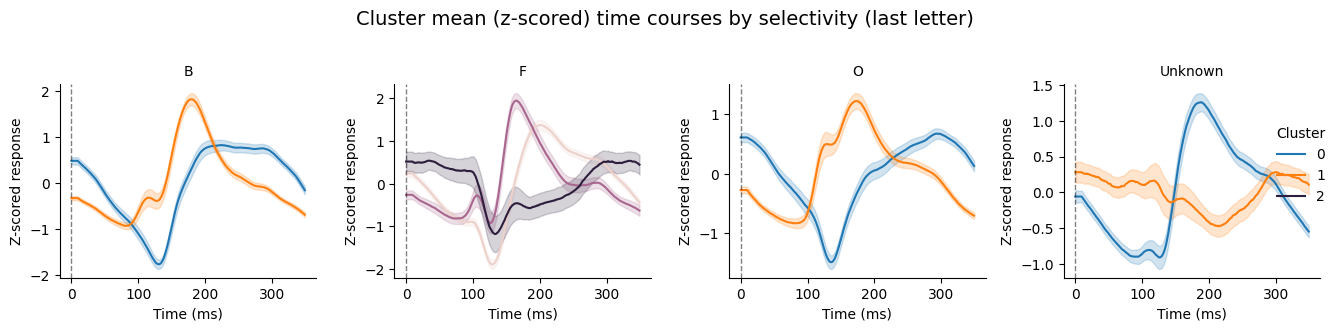

In [15]:
# facet_cluster_timecourses(
#     df_plot_roi, group_col="roi_clean",
#     title="Cluster mean (z-scored) time courses by ROI"
# )

facet_cluster_timecourses(
    df_plot_sel, group_col="sel",
    title="Cluster mean (z-scored) time courses by selectivity (last letter)"
)